In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr


In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
Dist_i = pd.read_csv("MLratio_i_distances.csv", sep=',')

for col in Dist_i.columns:
    newcol = col.strip()
    Dist_i.rename(columns={col:newcol}, inplace=True)
Dist_i = Dist_i.set_index("PGC")

# Dist_i = Dist_i[["DM_75","DMi_fid"]]

Dist_i.head(10)

,DM_75,DMi_fid,Mass_HI,Ms_i,Mb,F21,eF21,Qs,DMav_i,eDM_i,eDM_i_adj
PGC,,,,,,,,,,,
4,34.011709,33.410919,1.810891e+09,2.602457e+09,5.010942e+09,1.91,0.07,5.0,33.410533,0.205610,0.370283
16,34.491034,34.646528,1.754429e+09,2.405546e+10,2.638885e+10,1.19,0.20,5.0,34.664920,0.320493,0.396247
55,34.167913,33.811233,4.707702e+09,2.271251e+09,8.532494e+09,4.30,0.32,5.0,33.808665,0.265754,0.383876
68,35.108989,34.868604,4.193694e+09,1.157965e+10,1.715727e+10,1.61,0.27,5.0,34.879294,0.424903,0.424903
70,34.900087,35.358662,1.790008e+10,4.021006e+10,6.401717e+10,8.33,0.12,5.0,35.369549,0.216794,0.372811
76,34.937682,34.747891,9.832649e+09,7.655490e+10,8.963232e+10,4.42,0.11,5.0,34.758379,0.255859,0.381639
92,34.390188,32.893855,5.078582e+09,4.164620e+09,1.091913e+10,3.78,0.08,5.0,32.898087,0.210028,0.371282
96,36.577579,36.537371,2.951715e+10,1.909552e+11,2.302130e+11,2.93,0.16,5.0,36.548471,0.251173,0.380580
102,34.275251,34.317682,7.650315e+09,6.680367e+10,7.697859e+10,6.33,0.12,5.0,34.342285,0.230932,0.376006


In [4]:
df = pd.read_csv("MLratio_z_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
Dist_z = df.set_index("PGC")

# Dist_z = df[["DMz_fid"]]

Dist_z.head(10)

,DM_75,DMz_fid,Mass_HI,Ms_z,Mb,F21,eF21,Qs,DMav_z,eDM_z,eDM_z_adj
PGC,,,,,,,,,,,
4,34.011709,33.428209,1.810891e+09,2.531358e+09,4.939843e+09,1.91,0.07,5.0,33.423870,0.176364,0.364608
16,34.491034,34.588900,1.754429e+09,2.546793e+10,2.780132e+10,1.19,0.20,5.0,34.586808,0.262826,0.386439
55,34.167913,33.810979,4.707702e+09,2.249444e+09,8.510687e+09,4.30,0.32,5.0,33.824519,0.246539,0.382327
68,35.108989,34.775536,4.193694e+09,1.278220e+10,1.835981e+10,1.61,0.27,5.0,34.759090,0.392592,0.419205
70,34.900087,35.260574,1.790008e+10,4.492259e+10,6.872970e+10,8.33,0.12,5.0,35.261982,0.155408,0.359316
76,34.937682,34.704567,9.832649e+09,8.005030e+10,9.312773e+10,4.42,0.11,5.0,34.698988,0.190081,0.368071
92,34.390188,32.854782,5.078582e+09,4.401750e+09,1.115626e+10,3.78,0.08,5.0,32.859188,0.182555,0.366171
96,36.577579,36.549722,2.951715e+10,1.893309e+11,2.285887e+11,2.93,0.16,5.0,36.544751,0.174287,0.364083
102,34.275251,34.309980,7.650315e+09,6.747926e+10,7.765418e+10,6.33,0.12,5.0,34.308802,0.167572,0.362388


In [5]:
df = pd.read_csv("MLratio_r_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
Dist_r = df.set_index("PGC")

# Dist_r = df[["DMr_fid"]]

Dist_r.head(10)

,DM_75,DMr_fid,Mass_HI,Ms_r,Mb,F21,eF21,Qs,DMav_r,eDM_r,eDM_r_adj
PGC,,,,,,,,,,,
4,34.011709,33.454794,1.810891e+09,2.484183e+09,4.892668e+09,1.91,0.07,5.0,33.456132,0.196461,0.368316
16,34.491034,34.650373,1.754429e+09,2.379105e+10,2.612444e+10,1.19,0.20,5.0,34.638190,0.294909,0.392687
55,34.167913,33.823772,4.707702e+09,2.278585e+09,8.539828e+09,4.30,0.32,5.0,33.827555,0.251831,0.382023
68,35.108989,34.827453,4.193694e+09,1.210864e+10,1.768626e+10,1.61,0.27,5.0,34.824463,0.422837,0.424356
70,34.900087,35.355410,1.790008e+10,4.004375e+10,6.385086e+10,8.33,0.12,5.0,35.343745,0.181760,0.364676
76,34.937682,34.731166,9.832649e+09,7.701459e+10,9.009201e+10,4.42,0.11,5.0,34.739283,0.234476,0.377726
92,34.390188,32.921602,5.078582e+09,4.079203e+09,1.083372e+10,3.78,0.08,5.0,32.908941,0.194544,0.367841
96,36.577579,36.569313,2.951715e+10,1.826129e+11,2.218707e+11,2.93,0.16,5.0,36.567695,0.215957,0.373142
102,34.275251,34.297521,7.650315e+09,6.739076e+10,7.756567e+10,6.33,0.12,5.0,34.306845,0.201792,0.369635


In [6]:
df = pd.read_csv("MLratio_W1_distances.csv", sep=',')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
Dist_W1 = df.set_index("PGC")

Dist_W1 = Dist_W1.rename(columns={'DMw1_fid':'DM1_fid'})

# Dist_W1 = Dist_W1[["DMw1_fid"]]

Dist_W1.head(10)

,DM_75,DM1_fid,Mass_HI,Ms_W1,Mb,F21,eF21,Qw,DMav_W1,eDM_W1,eDM_W1_adj
PGC,,,,,,,,,,,
2,34.349020,34.490209,6.118492e+09,1.426708e+11,1.508084e+11,4.73,0.81,5.0,34.534845,0.308499,0.395344
4,34.011709,33.714909,1.810891e+09,1.844431e+09,4.252916e+09,1.91,0.07,4.0,33.704344,0.179224,0.333600
12,34.779466,34.987907,6.537934e+09,4.431121e+10,5.300666e+10,3.40,0.58,5.0,35.024030,0.257629,0.371047
16,34.491034,34.661762,1.754429e+09,2.350395e+10,2.583734e+10,1.19,0.20,5.0,34.669237,0.283086,0.383206
55,34.167913,33.949106,4.707702e+09,1.889488e+09,8.150731e+09,4.30,0.32,4.0,33.925564,0.247574,0.366245
68,35.108989,34.705024,4.193694e+09,1.407284e+10,1.965045e+10,1.61,0.27,5.0,34.681058,0.414186,0.445822
70,34.900087,35.148662,1.790008e+10,4.909873e+10,7.290584e+10,8.33,0.12,5.0,35.153204,0.189380,0.338451
76,34.937682,34.832315,9.832649e+09,6.838351e+10,8.146093e+10,4.42,0.11,5.0,34.858838,0.218873,0.352537
94,33.849365,33.855462,2.947329e+09,2.368500e+09,6.288448e+09,3.61,0.62,4.0,33.869524,0.299830,0.391204


In [7]:
Dist_W1.loc[1014]

DM_75         2.529719e+01
DM1_fid       2.577505e+01
Mass_HI       6.225564e+08
Ms_W1         1.109207e+09
Mb            1.937207e+09
F21           2.009690e+03
eF21          3.424900e+02
Qw            5.000000e+00
DMav_W1       2.575879e+01
eDM_W1        3.207116e-01
eDM_W1_adj    4.011769e-01
Name: 1014, dtype: float64

In [8]:
Dist_riz = pd.read_csv("MLratio_riz_distances.csv", sep=',')

for col in Dist_riz.columns:
    newcol = col.strip()
    Dist_riz.rename(columns={col:newcol}, inplace=True)
Dist_riz = Dist_riz.set_index("PGC")

# Dist_riz = Dist_riz[["DMriz_fid"]]

Dist_riz.head(10)

,DM_75,DMriz_fid,Mass_HI,Ms_riz,Mb,F21,eF21,Qs,DMav_riz,eDM_riz,eDM_riz_adj
PGC,,,,,,,,,,,
4,33.987953,33.421267,1.771699e+09,2.476099e+09,4.832459e+09,1.91,0.07,5.0,33.427796,0.181640,0.379584
16,34.460844,34.623502,1.706318e+09,2.360937e+10,2.587877e+10,1.19,0.20,5.0,34.621329,0.271609,0.398523
55,34.142010,33.803649,4.596718e+09,2.209518e+09,8.323153e+09,4.30,0.32,5.0,33.794886,0.244919,0.392904
68,35.068118,34.814419,4.038763e+09,1.166829e+10,1.703984e+10,1.61,0.27,5.0,34.824665,0.390959,0.423646
70,34.863482,35.317703,1.730666e+10,4.009340e+10,6.311125e+10,8.33,0.12,5.0,35.320739,0.152629,0.373477
76,34.901078,34.723933,9.506675e+09,7.472589e+10,8.736976e+10,4.42,0.11,5.0,34.718303,0.196631,0.382740
92,34.362141,32.880085,4.949069e+09,4.089370e+09,1.067163e+10,3.78,0.08,5.0,32.876425,0.183675,0.380012
96,36.496592,36.547618,2.739553e+10,1.730122e+11,2.094483e+11,2.93,0.16,5.0,36.553439,0.183663,0.380010
102,34.249348,34.304204,7.469960e+09,6.517174e+10,7.510679e+10,6.33,0.12,5.0,34.311332,0.175096,0.378206


In [9]:
# df = pd.read_csv("btfr_brent_updated.csv", sep='|')

# for col in df.columns:
#     newcol = col.strip()
#     df.rename(columns={col:newcol}, inplace=True)
    
# df = df.set_index("PGC")   

# db = df[["Vls"]]

# db.head()

In [10]:
def lambada(X):
    
    if ~np.isnan(X[col+"_riz"]):
        return X[col+"_riz"]
    elif ~np.isnan(X[col+"_i"]):
        return X[col+"_i"]
    elif ~np.isnan(X[col+"_r"]):
        return X[col+"_r"]
    elif ~np.isnan(X[col+"_z"]):
        return X[col+"_z"]
    else:
        return X[col]

df = Dist_i.join(Dist_riz, how='left', lsuffix='_i', rsuffix='_riz')
df = df.join(Dist_r, how='left')
df = df.join(Dist_z, how='left', lsuffix='_r', rsuffix='_z')
df = df.join(Dist_W1, how='outer') # .join(db)

df['Qs'] = df['Qs_i']
df['DM_75_w1'] = df['DM_75']

commons = ['DM_75', 'Mass_HI', 'Mb', 'F21', 'eF21', 'Qs']
for col in commons:
    df[col] = df.apply(lambada, axis=1)


df.head(10)

,DM_75_i,DMi_fid,Mass_HI_i,Ms_i,Mb_i,F21_i,eF21_i,Qs_i,DMav_i,eDM_i,...,Ms_W1,Mb,F21,eF21,Qw,DMav_W1,eDM_W1,eDM_W1_adj,Qs,DM_75_w1
PGC,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.426708e+11,1.508084e+11,4.73,0.81,5.0,34.534845,0.308499,0.395344,NaN,34.349020
4,34.011709,33.410919,1.810891e+09,2.602457e+09,5.010942e+09,1.91,0.07,5.0,33.410533,0.205610,...,1.844431e+09,4.832459e+09,1.91,0.07,4.0,33.704344,0.179224,0.333600,5.0,34.011709
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.431121e+10,5.300666e+10,3.40,0.58,5.0,35.024030,0.257629,0.371047,NaN,34.779466
16,34.491034,34.646528,1.754429e+09,2.405546e+10,2.638885e+10,1.19,0.20,5.0,34.664920,0.320493,...,2.350395e+10,2.587877e+10,1.19,0.20,5.0,34.669237,0.283086,0.383206,5.0,34.491034
55,34.167913,33.811233,4.707702e+09,2.271251e+09,8.532494e+09,4.30,0.32,5.0,33.808665,0.265754,...,1.889488e+09,8.323153e+09,4.30,0.32,4.0,33.925564,0.247574,0.366245,5.0,34.167913
68,35.108989,34.868604,4.193694e+09,1.157965e+10,1.715727e+10,1.61,0.27,5.0,34.879294,0.424903,...,1.407284e+10,1.703984e+10,1.61,0.27,5.0,34.681058,0.414186,0.445822,5.0,35.108989
70,34.900087,35.358662,1.790008e+10,4.021006e+10,6.401717e+10,8.33,0.12,5.0,35.369549,0.216794,...,4.909873e+10,6.311125e+10,8.33,0.12,5.0,35.153204,0.189380,0.338451,5.0,34.900087
76,34.937682,34.747891,9.832649e+09,7.655490e+10,8.963232e+10,4.42,0.11,5.0,34.758379,0.255859,...,6.838351e+10,8.736976e+10,4.42,0.11,5.0,34.858838,0.218873,0.352537,5.0,34.937682
92,34.390188,32.893855,5.078582e+09,4.164620e+09,1.091913e+10,3.78,0.08,5.0,32.898087,0.210028,...,NaN,1.067163e+10,3.78,0.08,NaN,NaN,NaN,NaN,5.0,NaN


In [11]:
old = pd.read_csv("../calibrators/DMs_EDD.csv.test", sep='|')

for col in old.columns:
    newcol = col.strip()
    old.rename(columns={col:newcol}, inplace=True)
old = old.set_index("pgc")

# oldCols = ["P0", "ggg", "rrr", "iii", "zzz"]
# for col in oldCols:
#     old[col] = old[col].apply(lambda x: np.float(x))


df = df.join(old, how='left', lsuffix='_new', rsuffix='_old')

df.head()

,DM_75_i,DMi_fid,Mass_HI_i,Ms_i,Mb_i,F21_i,eF21_i,Qs_i,DMav_i,eDM_i,...,pgc1,Nest,Vmodg,Nkt,N15,sglg,sgbg,RS,P0,DM_src
PGC,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73150,200275,4976,0,7,341.4922,20.7395,2,2.02,2
4,34.011709,33.410919,1.810891e+09,2.602457e+09,5.010942e+09,1.91,0.07,5.0,33.410533,0.205610,...,120,202766,4154,0,0,316.0587,18.4514,2,-2.75,1
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,210177,6279,0,1,286.4249,11.3510,2,0.56,2
16,34.491034,34.646528,1.754429e+09,2.405546e+10,2.638885e+10,1.19,0.20,5.0,34.664920,0.320493,...,16,211419,5434,0,1,287.6120,11.7030,2,0.92,1
55,34.167913,33.811233,4.707702e+09,2.271251e+09,8.532494e+09,4.30,0.32,5.0,33.808665,0.265754,...,55,0,4507,0,0,327.0996,19.7763,2,-2.83,1


In [12]:
for col in df.columns:
    print(col)

DM_75_i
DMi_fid
Mass_HI_i
Ms_i
Mb_i
F21_i
eF21_i
Qs_i
DMav_i
eDM_i
eDM_i_adj
DM_75_riz
DMriz_fid
Mass_HI_riz
Ms_riz
Mb_riz
F21_riz
eF21_riz
Qs_riz
DMav_riz
eDM_riz
eDM_riz_adj
DM_75_r
DMr_fid
Mass_HI_r
Ms_r
Mb_r
F21_r
eF21_r
Qs_r
DMav_r
eDM_r
eDM_r_adj
DM_75_z
DMz_fid
Mass_HI_z
Ms_z
Mb_z
F21_z
eF21_z
Qs_z
DMav_z
eDM_z
eDM_z_adj
DM_75
DM1_fid
Mass_HI
Ms_W1
Mb
F21
eF21
Qw
DMav_W1
eDM_W1
eDM_W1_adj
Qs
DM_75_w1
Vh
Vls
V3k
Vmod
f_cosmology
logWimx
logWimx_e
inc
Sqlt
Wqlt
DM_best
dDM_best
DMr
dDMr
RMS_r
DMr_raw
DMi
dDMi
RMS_i
DMi_raw
DMz
dDMz
RMS_z
DMz_raw
DM_w1
dDM_w1
RMS_w1
DMw1_raw
ggg
rrr
iii
zzz
w1
w2
RA
DEC
gl
gb
sgl
sgb
pgc1
Nest
Vmodg
Nkt
N15
sglg
sgbg
RS
P0
DM_src


In [13]:
len(df)

10153

In [14]:
df['logMs_riz'] = np.log10(df.Ms_riz)
df['logMs_r'] = np.log10(df.Ms_r)
df['logMs_i'] = np.log10(df.Ms_i)
df['logMs_z'] = np.log10(df.Ms_z)
df['logMs_W1'] = np.log10(df.Ms_W1)

In [15]:
df[['DMr_fid', 'DMi_fid', 'DMz_fid', 'DMriz_fid', 'DM1_fid']+['DMav_r', 'DMav_i', 'DMav_z', 'DMav_riz', 'DMav_W1']]

,DMr_fid,DMi_fid,DMz_fid,DMriz_fid,DM1_fid,DMav_r,DMav_i,DMav_z,DMav_riz,DMav_W1
PGC,,,,,,,,,,
2,NaN,NaN,NaN,NaN,34.490209,NaN,NaN,NaN,NaN,34.534845
4,33.454794,33.410919,33.428209,33.421267,33.714909,33.456132,33.410533,33.423870,33.427796,33.704344
12,NaN,NaN,NaN,NaN,34.987907,NaN,NaN,NaN,NaN,35.024030
16,34.650373,34.646528,34.588900,34.623502,34.661762,34.638190,34.664920,34.586808,34.621329,34.669237
55,33.823772,33.811233,33.810979,33.803649,33.949106,33.827555,33.808665,33.824519,33.794886,33.925564
68,34.827453,34.868604,34.775536,34.814419,34.705024,34.824463,34.879294,34.759090,34.824665,34.681058
70,35.355410,35.358662,35.260574,35.317703,35.148662,35.343745,35.369549,35.261982,35.320739,35.153204
76,34.731166,34.747891,34.704567,34.723933,34.832315,34.739283,34.758379,34.698988,34.718303,34.858838
92,32.921602,32.893855,32.854782,32.880085,NaN,32.908941,32.898087,32.859188,32.876425,NaN


In [16]:
import copy 

df_paper = copy.deepcopy(df)

# M_gas = 1.33 x M_HI = 1.33 x 2.36X10^5 x (3950/75)^2 x 69.07   => log Mgass = 10.78 not 7.851
df_paper['flag'] = 1
adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
df_paper.loc[adhi_list]['flag'] = 0

df_paper['DM_av'] = df_paper[["DMav_riz", "DMav_W1"]].mean(axis=1)


indx = (df_paper.Qs<3) & (df_paper.Qw>=3)
df_paper['DM_av'][indx] = df_paper['DMav_W1'][indx]

indx = (df_paper.Qs>=3) & (df_paper.Qw<3)
df_paper['DM_av'][indx] = df_paper['DMav_riz'][indx]

df_paper['Dav'] = 10**((df_paper.DM_av-25)/5.)

df_paper['DM_75'] = df_paper[['DM_75_riz', 'DM_75_w1']].mean(axis=1)
df_paper['D75'] = 10**((df_paper.DM_75-25)/5.)

df_paper['logMs_av'] = df_paper[['logMs_riz', 'logMs_W1']].mean(axis=1)


indx = (df_paper.Qs<3) & (df_paper.Qw>=3)
df_paper['logMs_av'][indx] = df_paper['logMs_W1'][indx]

indx = (df_paper.Qs>=3) & (df_paper.Qw<3)
df_paper['logMs_av'][indx] = df_paper['logMs_riz'][indx]


df_paper['Ms'] = 10**df_paper.logMs_av

df_paper['Mass_HI'] = 2.356E5 * df_paper.F21 * (df_paper.D75**2)

df_paper['logMgas'] = np.log10(1.33*(10**(np.log10(df_paper.Mass_HI))))
df_paper['Mgas'] = 1.33*(10**(np.log10(df_paper.Mass_HI)))

df_paper['Mb'] = df_paper.Ms+df_paper.Mgas
df_paper['logMb'] = np.log10(df_paper.Mb)

old = pd.read_csv("../calibrators/corrected_mags_linewidth_all.csv", sep='|')
for col in old.columns:
    newcol = col.strip()
    old.rename(columns={col:newcol}, inplace=True)

old = old.set_index("pgc")

df_paper = df_paper.join(old[['inc_e']], how='left')


df_paper["DMr_err"]   = df_paper.eDM_r
df_paper["DMi_err"]   = df_paper.eDM_i
df_paper["DMz_err"]   = df_paper.eDM_z
df_paper["DMriz_err"] = df_paper.eDM_riz
df_paper["DM1_err"]   = df_paper.eDM_W1

df_paper["eDMr_adj"]   = df_paper.eDM_r_adj
df_paper["eDMi_adj"]   = df_paper.eDM_i_adj
df_paper["eDMz_adj"]   = df_paper.eDM_z_adj
df_paper["eDMriz_adj"] = df_paper.eDM_riz_adj
df_paper["eDM1_adj"]   = df_paper.eDM_W1_adj

df_paper['DM_err'] = np.nanmax(df_paper[["DMriz_err","DM1_err"]], axis=1)
df_paper['eDM_adj'] = np.nanmax(df_paper[["eDMriz_adj","eDM1_adj"]], axis=1)

df_paper["flag"][df_paper.DM_err>0.8] = 0

cols = ["flag", "DM_av", "DM_err", "eDM_adj", "DMriz_fid", "DMriz_err", "eDMriz_adj"]
cols += ["DMr_fid", "DMr_err", "eDMr_adj"]
cols += ["DMi_fid", "DMi_err", "eDMi_adj"]
cols += ["DMz_fid", "DMz_err", "eDMz_adj"]
cols += ["DM1_fid", "DM1_err", "eDM1_adj"]
cols += ["DM_75", 'pgc1', 'Nest']
cols += ['logMs_av', 'logMs_riz', 'logMs_r', 'logMs_i', 'logMs_z', 'logMs_W1']
cols += ['logMgas', 'logMb']
cols += ['Vh', 'Vls', 'V3k', 'Vmod', 'f_cosmology']
cols += ['logWimx', 'logWimx_e', 'F21', 'eF21', 'inc', 'inc_e']
cols += ['ggg', 'rrr', 'iii', 'zzz', 'w1']
cols += ['Qs', 'Qw']
cols += ['RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'Nkt', 'N15', 'sglg', 'sgbg', 'Vmodg']

df_paper = df_paper[cols]


# df_paper = df_paper.rename(columns={"V3k_old":"V3k"})
# df_paper = df_paper.rename(columns={"Vmod_old":"Vmod"})

df_paper.ggg[df_paper.ggg.astype(np.float64)<=0]=-1000000
df_paper.rrr[df_paper.rrr.astype(np.float64)<=0]=-1000000
df_paper.iii[df_paper.iii.astype(np.float64)<=0]=-1000000
df_paper.zzz[df_paper.zzz.astype(np.float64)<=0]=-1000000
df_paper.w1[df_paper.w1.astype(np.float64)<=0]=-1000000


df_paper.head()

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py

,flag,DM_av,DM_err,eDM_adj,DMriz_fid,DMriz_err,eDMriz_adj,DMr_fid,DMr_err,eDMr_adj,...,DEC,gl,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.534845,0.308499,0.395344,NaN,NaN,NaN,NaN,NaN,NaN,...,47.2745,113.9553,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976
4,1,33.566070,0.181640,0.379584,33.421267,0.181640,0.379584,33.454794,0.196461,0.368316,...,23.0876,107.8322,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154
12,1,35.024030,0.257629,0.371047,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.3739,90.1920,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279
16,1,34.645283,0.283086,0.398523,34.623502,0.271609,0.398523,34.650373,0.294909,0.392687,...,-5.1587,91.6005,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434
55,1,33.860225,0.247574,0.392904,33.803649,0.244919,0.392904,33.823772,0.251831,0.382023,...,33.6009,110.9496,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507


In [17]:
df_paper.loc.__setitem__((90661, ('DM1_fid')), np.nan)
df_paper.loc.__setitem__((90661, ('DM1_err')), np.nan)

df_paper.loc.__setitem__((90661, ('DM_av')), df_paper.loc[90661]['DMriz_fid'])

# df_paper.loc[90661]

In [18]:
tfr4 = pd.read_csv("EDD_CF4_TF.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    tfr4.rename(columns={col:newcol}, inplace=True)

tfr4 = tfr4.set_index("PGC")
tfr4 = tfr4[["PGC1", "Nest"]]

df_paper = df_paper.join(tfr4, how='left', lsuffix='_new', rsuffix='_old')

In [19]:
df_paper.head(20)

,flag,DM_av,DM_err,eDM_adj,DMriz_fid,DMriz_err,eDMriz_adj,DMr_fid,DMr_err,eDMr_adj,...,gb,sgl,sgb,Nkt,N15,sglg,sgbg,Vmodg,PGC1,Nest_old
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.534845,0.308499,0.395344,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.6992,341.6440,20.7388,0,7,341.4922,20.7395,4976,73150.0,200275.0
4,1,33.566070,0.181640,0.379584,33.421267,0.181640,0.379584,33.454794,0.196461,0.368316,...,-38.2729,316.0587,18.4514,0,0,316.0587,18.4514,4154,120.0,202766.0
12,1,35.024030,0.257629,0.371047,NaN,NaN,NaN,NaN,NaN,NaN,...,-65.9300,286.4249,11.3511,0,1,286.4249,11.3510,6279,12.0,210177.0
16,1,34.645283,0.283086,0.398523,34.623502,0.271609,0.398523,34.650373,0.294909,0.392687,...,-64.8656,287.6119,11.7030,0,1,287.6120,11.7030,5434,16.0,211419.0
55,1,33.860225,0.247574,0.392904,33.803649,0.244919,0.392904,33.823772,0.251831,0.382023,...,-28.0857,327.0996,19.7763,0,0,327.0996,19.7763,4507,55.0,0.0
68,1,34.752862,0.414186,0.445822,34.814419,0.390959,0.423646,34.827453,0.422837,0.424356,...,-75.8101,274.3903,7.1770,0,0,274.3903,7.1770,7480,68.0,0.0
70,1,35.236972,0.189380,0.373477,35.317703,0.152629,0.373477,35.355410,0.181760,0.364676,...,-40.9837,313.2487,17.7662,0,1,313.2488,17.7663,6561,70.0,209949.0
76,1,34.788570,0.218873,0.382740,34.723933,0.196631,0.382740,34.731166,0.234476,0.377726,...,-32.6709,322.1726,19.1316,0,1,322.1729,19.1316,6676,76.0,209247.0
92,1,32.876425,0.183675,0.380012,32.880085,0.183675,0.380012,32.921602,0.194544,0.367841,...,-47.9564,305.8667,16.2222,0,0,305.8667,16.2222,5082,92.0,0.0


In [20]:
df_paper = df_paper.reset_index()

In [21]:
df_paper['pgc1_'] = df_paper.apply(lambda X: X.PGC1 if X.PGC1>0 else X.pgc1, axis=1)
df_paper['Nest_'] = df_paper.apply(lambda X: X.Nest_old if X.Nest_old>0 else X.Nest_new, axis=1)

In [22]:
df_paper['pgc1'] = df_paper['pgc1_']
df_paper['Nest_new'] = df_paper['Nest_']

df_paper = df_paper.drop(["Nest_old", "PGC1"], axis=1)
df_paper = df_paper.drop(["pgc1_", "Nest_"], axis=1)

df_paper = df_paper.rename(columns={"pgc1":"PGC1"})
df_paper = df_paper.rename(columns={"Nest_new":"Nest"})

df_paper.Nest[df_paper.Nest.astype(np.float64)<=0]=-1000000
df_paper.PGC1[df_paper.PGC1.astype(np.float64)<=0]=-1000000

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [23]:
flags = pd.read_csv("BTFR_flags.csv", sep='|')
flags = flags[['PGC', 'flag']]
flags = flags.set_index('PGC')

try:
    df_paper = df_paper.set_index('PGC')
except:
    pass



df_paper = df_paper.join(flags, how='left', lsuffix='_l', rsuffix='_r')

df_paper['flag_l'] = df_paper['flag_r']
df_paper = df_paper.rename(columns={"flag_l":"flag"})
df_paper = df_paper.drop(columns=['flag_r'])

df_paper['flag'][((df_paper.DMriz_err>0.8) | (df_paper.DM1_err>0.8))] = 0

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
print(df_paper.columns)
len(df_paper)

Index([u'flag', u'DM_av', u'DM_err', u'eDM_adj', u'DMriz_fid', u'DMriz_err',
       u'eDMriz_adj', u'DMr_fid', u'DMr_err', u'eDMr_adj', u'DMi_fid',
       u'DMi_err', u'eDMi_adj', u'DMz_fid', u'DMz_err', u'eDMz_adj',
       u'DM1_fid', u'DM1_err', u'eDM1_adj', u'DM_75', u'PGC1', u'Nest',
       u'logMs_av', u'logMs_riz', u'logMs_r', u'logMs_i', u'logMs_z',
       u'logMs_W1', u'logMgas', u'logMb', u'Vh', u'Vls', u'V3k', u'Vmod',
       u'f_cosmology', u'logWimx', u'logWimx_e', u'F21', u'eF21', u'inc',
       u'inc_e', u'ggg', u'rrr', u'iii', u'zzz', u'w1', u'Qs', u'Qw', u'RA',
       u'DEC', u'gl', u'gb', u'sgl', u'sgb', u'Nkt', u'N15', u'sglg', u'sgbg',
       u'Vmodg'],
      dtype='object')


10153

In [25]:
df_brent = pd.read_csv("btfr_brent_updated.csv", sep='|')
for col in df_brent.columns:
    newcol = col.strip()
    df_brent.rename(columns={col:newcol}, inplace=True)
df_brent = df_brent.set_index("PGC")
df_brent = df_brent[['Vhel', 'Vls', 'v3k', 'f', 'Vhg', 'Vlsg', 'V3kg', 'fg']]

df_paper_ = df_paper.join(df_brent, how='inner', lsuffix='_org', rsuffix='_brt')

df_paper_['f_cosmology'] = df_paper_.f
df_paper_['Vh'] = df_paper_.Vhel
df_paper_['Vls_org'] = df_paper_.Vls_brt
df_paper_['V3k'] = df_paper_.v3k


df_paper_ = df_paper_.drop(["f", "Vhel", "Vls_brt", "v3k","Vmodg","Vmod"], axis=1)
df_paper_ = df_paper_.rename(columns={"Vls_org":"Vls"})


df_paper_ = df_paper_.reset_index()

df_paper_.to_csv('BTFR_CF4_Dist_bar.MLratio.csv', sep='|', index=False)

print(df_paper_.columns)

len(df_paper_)

Index([u'PGC', u'flag', u'DM_av', u'DM_err', u'eDM_adj', u'DMriz_fid',
       u'DMriz_err', u'eDMriz_adj', u'DMr_fid', u'DMr_err', u'eDMr_adj',
       u'DMi_fid', u'DMi_err', u'eDMi_adj', u'DMz_fid', u'DMz_err',
       u'eDMz_adj', u'DM1_fid', u'DM1_err', u'eDM1_adj', u'DM_75', u'PGC1',
       u'Nest', u'logMs_av', u'logMs_riz', u'logMs_r', u'logMs_i', u'logMs_z',
       u'logMs_W1', u'logMgas', u'logMb', u'Vh', u'Vls', u'V3k',
       u'f_cosmology', u'logWimx', u'logWimx_e', u'F21', u'eF21', u'inc',
       u'inc_e', u'ggg', u'rrr', u'iii', u'zzz', u'w1', u'Qs', u'Qw', u'RA',
       u'DEC', u'gl', u'gb', u'sgl', u'sgb', u'Nkt', u'N15', u'sglg', u'sgbg',
       u'Vhg', u'Vlsg', u'V3kg', u'fg'],
      dtype='object')


10153

In [26]:
len(df_paper_.columns)

62

In [27]:
from astropy.table import Table, Column

table   = np.genfromtxt('BTFR_CF4_Dist_bar.MLratio.csv' , delimiter='|', 
                        filling_values=-1000000, names=True, dtype=None, encoding=None)

colnames = table.dtype.names

## table is a structured array
myTable = {}
for name in table.dtype.names:
    myTable[name] = table[name]
table = myTable
## table is now a dictionary

myTable = Table()

for key in colnames:
    if key in ["pgc", "PGC"]:
        myTable.add_column(Column(data=table[key], name=key))
    elif key in ["f_cosmology", 'logMs_av', 'logMs_riz','logMs_r','logMs_i','logMs_z','logMs_W1','logMgas','logMb','logWimx','logWimx_e', 'fg']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))    
    elif key in ["Vh", "Vls", 'V3k', 'Vmod', 'Vmodg', 'inc', 
                 'Qs', 'Qw', 'Nkt', 'N15', '1PGC', 'Nest', 'flag', 'Vhg', 'Vlsg', 'V3kg']:
        myTable.add_column(Column(data=table[key], name=key, dtype=np.dtype(int)))
    elif key in ['RA', 'DEC', 'gl', 'gb', 'sgl', 'sgb', 'sglg', 'sgbg']:
        myTable.add_column(Column(data=table[key], name=key, format='%0.4f'))      
    else:
        myTable.add_column(Column(data=table[key], name=key, format='%0.2f'))

## to be used on EDD
myTable.write('BTFR_CF4_Dist_bar_MLratio', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

In [28]:
for cols in df.columns:
    print(cols)

DM_75_i
DMi_fid
Mass_HI_i
Ms_i
Mb_i
F21_i
eF21_i
Qs_i
DMav_i
eDM_i
eDM_i_adj
DM_75_riz
DMriz_fid
Mass_HI_riz
Ms_riz
Mb_riz
F21_riz
eF21_riz
Qs_riz
DMav_riz
eDM_riz
eDM_riz_adj
DM_75_r
DMr_fid
Mass_HI_r
Ms_r
Mb_r
F21_r
eF21_r
Qs_r
DMav_r
eDM_r
eDM_r_adj
DM_75_z
DMz_fid
Mass_HI_z
Ms_z
Mb_z
F21_z
eF21_z
Qs_z
DMav_z
eDM_z
eDM_z_adj
DM_75
DM1_fid
Mass_HI
Ms_W1
Mb
F21
eF21
Qw
DMav_W1
eDM_W1
eDM_W1_adj
Qs
DM_75_w1
Vh
Vls
V3k
Vmod
f_cosmology
logWimx
logWimx_e
inc
Sqlt
Wqlt
DM_best
dDM_best
DMr
dDMr
RMS_r
DMr_raw
DMi
dDMi
RMS_i
DMi_raw
DMz
dDMz
RMS_z
DMz_raw
DM_w1
dDM_w1
RMS_w1
DMw1_raw
ggg
rrr
iii
zzz
w1
w2
RA
DEC
gl
gb
sgl
sgb
pgc1
Nest
Vmodg
Nkt
N15
sglg
sgbg
RS
P0
DM_src
logMs_riz
logMs_r
logMs_i
logMs_z
logMs_W1


In [29]:
DM_W1 = df["DM1_fid"].values
DM_r = df["DMr_fid"].values
DM_i = df["DMi_fid"].values
DM_z = df["DMz_fid"].values
DM_riz = df["DMriz_fid"].values
DM_75 = df["DM_75"].values
Vls = df["Vls"].values

iii = df["iii"].values
w11 = df["w1"].apply(lambda x: np.float64(x)).values

In [30]:
w11

array([11.89, 16.07, 13.59, ...,  0.  ,  0.  , 15.02])

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'W1')

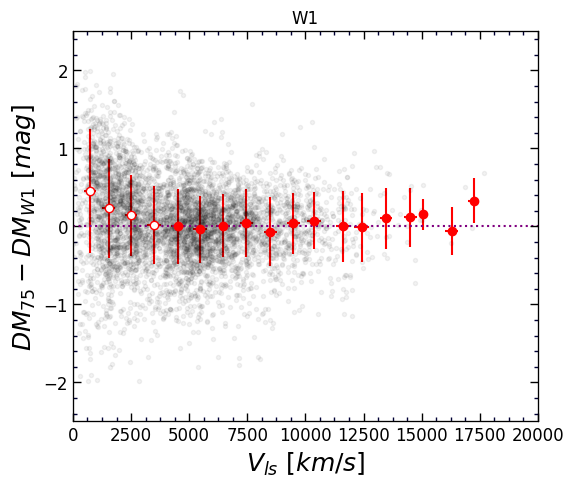

In [31]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vls
Y = DM_W1-DM_75
# Z = Vls

X = X[Y>-100]
Y = Y[Y>-100]

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   


for i in np.arange(0,4000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{W1}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("W1")

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'<riz>')

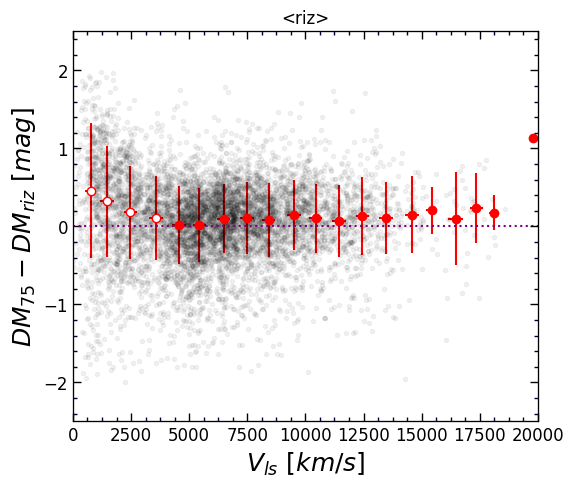

In [32]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vls
Y = DM_riz-DM_75
# Z = Vls

X = X[Y>-100]
Y = Y[Y>-100]

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   


for i in np.arange(0,4000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{riz}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("<riz>")

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


Text(0.5,1,'<riz>')

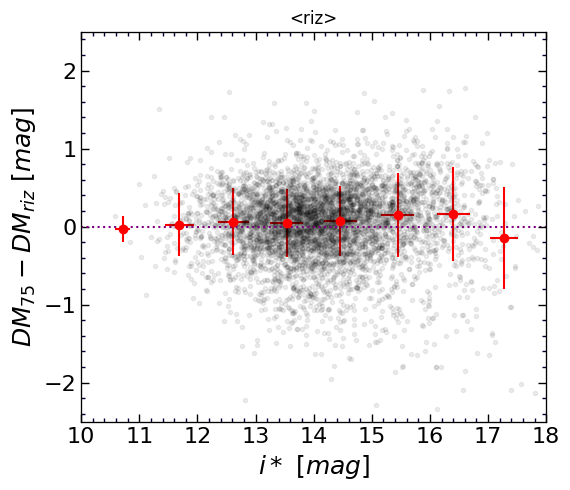

In [33]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = iii
Y = DM_riz-DM_75
Z = Vls

X = X[Z>4000]
Y = Y[Z>4000]

ax.plot(X, Y, 'k.', alpha=0.07)

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{riz}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("<riz>")

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


Text(0.5,1,'W1')

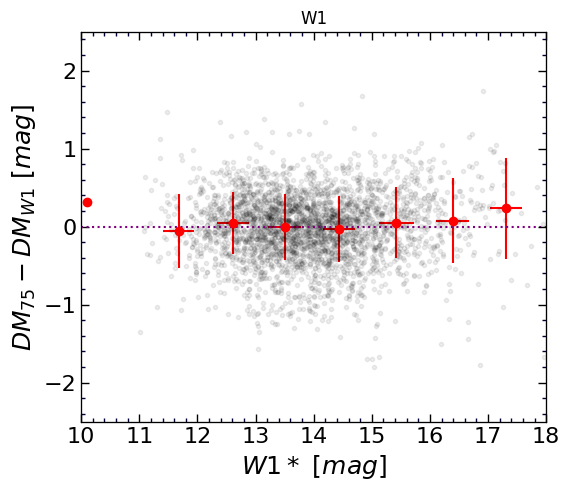

In [34]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = w11
Y = DM_W1-DM_75
Z = Vls

X = X[Z>4000]
Y = Y[Z>4000]

ax.plot(X, Y, 'k.', alpha=0.07)

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$W1* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{W1}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("W1")

In [35]:
df["w1"].values

array([' 11.89 ', ' 16.07 ', ' 13.59 ', ..., '  0.00 ', '  0.00 ',
       ' 15.02 '], dtype=object)

In [36]:
Y

array([ 0.14118943, -0.27304412,  0.20844161, ...,  0.6521962 ,
        0.1804466 , -0.59731987])

In [37]:
w11

array([11.89, 16.07, 13.59, ...,  0.  ,  0.  , 15.02])

In [38]:
cf3 = pd.read_csv("../calibrators/cf3.csv", sep='|')

for col in cf3.columns:
    newcol = col.strip()
    cf3.rename(columns={col:newcol}, inplace=True)

cf3.set_index('PGC', inplace=True)

cf3['DM_cf3'] = cf3['DM']
cf3 = cf3[['DM_cf3']]

df34 = df_paper.join(cf3, how='inner')

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
def constant(x,delta):
    return delta

(array([-0.07262708]), array([[6.7853786e-05]]))
(-0.046831733993986546, 0.2951470796959941)


Text(2500,-2,'$\\Delta =-0.047\\pm0.295$ [mag]')

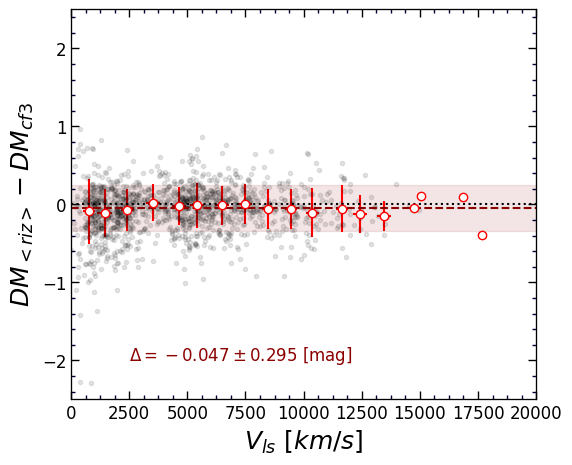

In [40]:
dff = df34[df34.Qs>2].dropna()

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vls.values
Y = dff.DMriz_fid.values-dff.DM_cf3.values

Ye = np.sqrt(dff.DMriz_err.values**2+0.4**2)

fit, cov = curve_fit(constant, X, Y, sigma=Ye)
print(fit, cov)

ax.plot(X, Y, 'k.', alpha=0.1)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = np.median(Y)
std = np.std(Y-med)
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -2, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

(array([-0.04694369]), array([[6.57340705e-05]]))
(-0.014103206008797997, 0.28723730137176245)


Text(2500,-2,'$\\Delta =-0.014\\pm0.287$ [mag]')

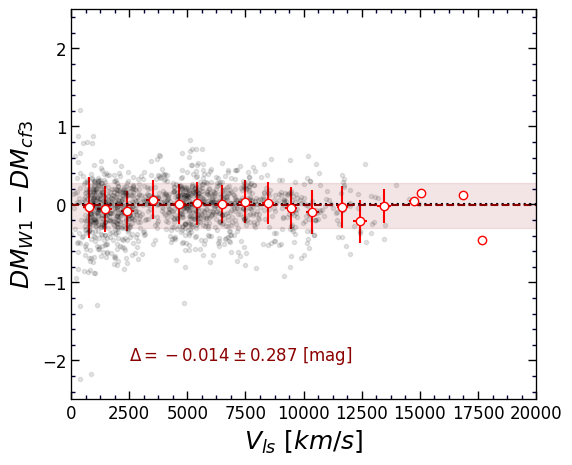

In [41]:
dff = df34[df34.Qw>2].dropna()

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vls.values
Y = dff.DM1_fid.values-dff.DM_cf3.values

Ye = np.sqrt(dff.DM1_err.values**2+0.4**2)

fit, cov = curve_fit(constant, X, Y, sigma=Ye)
print(fit, cov)

ax.plot(X, Y, 'k.', alpha=0.1)

X = X[Y<1]
Y = Y[Y<1]

X = X[Y>-1.5]
Y = Y[Y>-1.5]

for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{W1}-DM_{cf3}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = np.median(Y)
std = np.std(Y-med)
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -2, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

(array([-0.02415235]), array([[1.08585863e-05]]))
(-0.024152350694859794, 0.1348647634172428)


Text(2500,-0.6,'$\\Delta =-0.024\\pm0.135$ [mag]')

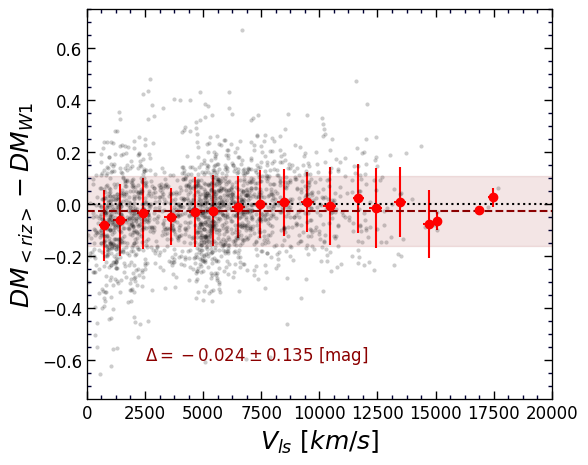

In [42]:
dff = df_paper[(df_paper.Qs>2)&(df_paper.Qw>3)].dropna() # 
# dff = df[(df.Qs>2)]

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vls.values
Y = dff.DMriz_fid.values-dff.DM1_fid.values
Ye = np.sqrt(dff.DMriz_err.values**2+dff.DM1_err.values**2)

fit, cov = curve_fit(constant, X, Y, sigma=Ye)
print(fit, cov)

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[np.abs(Y)<0.40]
Y = Y[np.abs(Y)<0.40]


for i in np.arange(0,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$DM_{75} - DM_{fid}$', fontsize=18)
ax.set_ylabel(r'$DM_{<riz>}-DM_{W1}$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='k')

set_axes(ax, (0,20000), (-.75,.75), fontsize=12)

# ax.set_title("BTFR: W1-band")

med = fit[0] #np.median(Y)
std = np.std(Y-fit[0])
y = np.asarray([med,med])
ax.plot([0,20000], y, '--', color='darkred')
ax.fill_between([0,20000], y+std, y-std, color='darkred', alpha=0.10)

print(med,std)

ax.text(2500, -0.6, r"$\Delta =" + '%.3f'%med+'\pm'+'%.3f'%std+'$'+ ' [mag]', color='darkred', fontsize=12)

In [43]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [44]:
def myHubble(D, H0):
    return H0    


def plotHubble(ax, X, Y, Ye, band="", color='red'):
       
    ax.plot(X, 10**Y, 'k.', alpha=0.05, mec='white', ms=5)
    
#     m = np.median(Y[X>4000])
#     e1 = np.std(Y[X>4000])/np.sqrt(len(Y[X>4000])) 
#     e2 = m/np.sqrt(len(Y[X>4000])) 
#     e = np.sqrt(e1**2)
#     H0e_fit = 10**m*e*np.log(10)    
    
    for i in np.arange(0,18000, 1000):
        xp = []
        yp = []
        ype  = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+1000 and Y[ii]>-10000: #and Ye[ii]>0:
                xp.append(xi)
                yp.append(Y[ii])
                ype.append(Ye[ii])
        if len(xp)>2:
            yp = np.asarray(yp)
            ype = np.asarray(ype)
            
            fit, cov = curve_fit(myHubble, xp, yp, sigma=ype)
            yy = fit[0]
            e = np.sqrt(cov[0])
            H0e_fit = (10**yy)*np.log(10.)*np.sqrt(cov[0])
            H0 = 10**yy  
    
            if np.median(xp)>4000:
                ax.errorbar(i+500, 10**yy, yerr=H0e_fit, xerr=np.std(xp), fmt='o', 
                        color=color, ms=5, capsize=2)     
            else:
                ax.errorbar(i+500, 10**yy, yerr=H0e_fit, xerr=np.std(xp), fmt='o', 
                        color=color, ms=5, capsize=2)  
            

    
    fit, cov = curve_fit(myHubble, X[X>4000], Y[X>4000], sigma=Ye[X>4000])
    yy = fit[0]
    sigma = np.std(Y[X>4000]-yy)
    
    
    ind = ((X>4000)&(np.abs(Y-yy)<3.5*sigma))
    fit, cov = curve_fit(myHubble, X[ind], Y[ind], sigma=Ye[ind])
    yy = fit[0]
    H0e_fit = (10**yy)*np.log(10.)*np.sqrt(cov[0])
    H0 = 10**yy  

    ax.plot([4000,20000], [H0, H0], '--', color='blue')

    x_ax, y_ax = set_axes(ax, (0,20000), (35,150), fontsize=14) 

    ax.set_yscale('log')

    from matplotlib.ticker import MultipleLocator

    from matplotlib.ticker import NullFormatter
    
    ax.set_yticks(np.arange(30,150, step=30))
    ax.yaxis.set_major_formatter(NullFormatter())  
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    plt.yticks([40, 70, 100, 130], ('40', '70', '100','130'))


    y_ax.set_yticks(np.arange(30,150, step=30))
    y_ax.set_yscale('log')
    y_ax.yaxis.set_major_formatter(NullFormatter())  
    y_ax.yaxis.set_minor_formatter(NullFormatter())
    y_ax.yaxis.set_major_locator(MultipleLocator(30))
    y_ax.yaxis.set_minor_locator(MultipleLocator(10))


    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = 0.80*Xlm[0]+0.20*Xlm[1]
    y0 = 0.95*Ylm[0]+0.05*Ylm[1] 
    unit= '   km/s/Mpc'
    ax.text(x0,y0, r"$ \langle H_0 \rangle_{"+band+"}= $"+"%.1f" % H0+'$\pm$'+"%.1f" % H0e_fit+unit, fontsize=14, 
            color='blue', backgroundcolor='white')

    ax.xaxis.set_major_formatter(OOMFormatter(3, "%d"))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(3,3))



/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log10
/media/Data/Hom

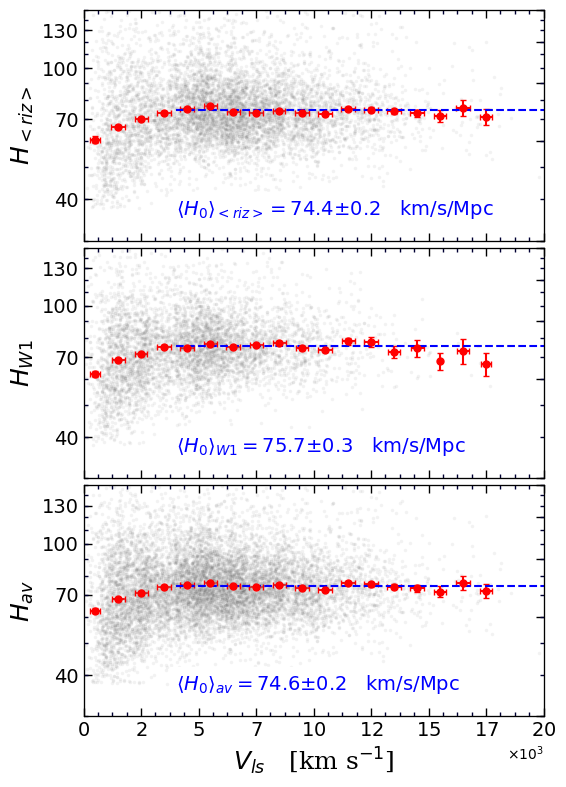

In [45]:
fig = py.figure(figsize=(5, 11.8), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(4,1) ; p=0

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

####################################################
####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[(df_paper.Qs>2)&(df_paper.logWimx>0)][["Vls","f_cosmology","DMriz_fid","eDMriz_adj"]].dropna()
X = dff.Vls.values
Y  = np.log10(dff.Vls.values*dff.f_cosmology.values)-(dff.DMriz_fid.values-25)/5.
Ye = dff.eDMriz_adj.values/5.

Y0 = dff.Vls.values*dff.f_cosmology.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DMriz_fid.values

ind, = np.where(np.abs(Y0)<1.5)

plotHubble(ax, X[ind], Y[ind], Ye[ind], band="<riz>")
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{<riz>}$', fontsize=18, fontdict=font) 
# ####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[(df_paper.Qw>2)&(df_paper.logWimx>0)][["Vls","f_cosmology","DM1_fid","eDM1_adj"]].dropna()
X = dff.Vls.values
Y  = np.log10(dff.Vls.values*dff.f_cosmology.values)-(dff.DM1_fid.values-25)/5.
Ye = dff.eDM1_adj.values/5.

Y0 = dff.Vls.values*dff.f_cosmology.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DM1_fid.values

ind, = np.where(np.abs(Y0)<1.5)
plotHubble(ax, X[ind], Y[ind], Ye[ind], band="W1")
plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{W1}$', fontsize=18, fontdict=font) 

####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[((df_paper.Qw>2)|(df_paper.Qs>2))&(df_paper.logWimx>0)][["Vls","f_cosmology","DM_av","eDM_adj"]].dropna()
X = dff.Vls.values#*dff.f_cosmology.values
Y  = np.log10(dff.Vls.values*dff.f_cosmology.values)-(dff.DM_av.values-25)/5.
Ye = dff.eDM_adj.values/5.

Y0 = dff.Vls.values*dff.f_cosmology.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DM_av.values

ind, = np.where(np.abs(Y0)<1.5)
plotHubble(ax, X[ind], Y[ind], Ye[ind], band="av")
# plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{av}$', fontsize=18, fontdict=font) 



ax.set_xlabel(r'$V_{ls} $'+'   [km s'+r'$^{-1}$'+']', fontsize=18, fontdict=font) 


plt.subplots_adjust(hspace=0.03, wspace=0.2)

/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10
/media/Data/Home/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


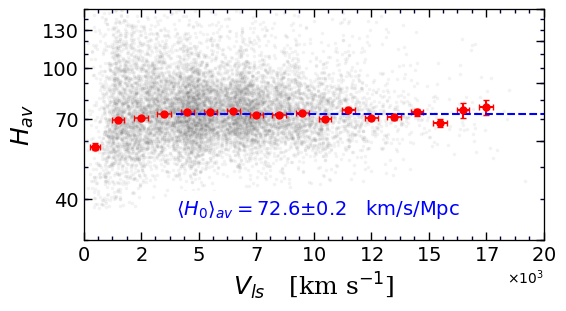

In [46]:
fig = py.figure(figsize=(5, 11.8), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(4,1) ; p=0

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }


####################################################
ax = plt.subplot(gs[p]) ; p+=1

dff = df_paper[((df_paper.Qw>2)|(df_paper.Qs>2))&(df_paper.logWimx>0)]
X = dff.V3k.values
Y  = np.log10(dff.Vmod.values)-(dff.DM_av.values-25)/5.
Ye = dff[["DMriz_err", "DM1_fid"]].mean(axis=1).values/5.

Y0 = dff.Vmod.values
DM_75 = 5*np.log10(Y0/75.)+25.
Y0 = DM_75-dff.DM_av.values

ind, = np.where(np.abs(Y0)<1.5)
plotHubble(ax, X[ind], Y[ind], Ye[ind], band="av")
# plt.setp(ax.get_xticklabels(), visible=False)
ax.set_ylabel(r'$H_{av}$', fontsize=18, fontdict=font) 



ax.set_xlabel(r'$V_{ls} $'+'   [km s'+r'$^{-1}$'+']', fontsize=18, fontdict=font) 


plt.subplots_adjust(hspace=0.03, wspace=0.2)